In [10]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
import ast
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
experiment_name = 'e'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

In [3]:
bad = []
for isub in range(exp.nsub):
    try:
        beh = exp.load_behavior(isub)
    except:
        bad.append(isub)

In [4]:
time_window = 25 
time_step = 25
trial_bin_size = 15
n_splits = 30
group_dict = OrderedDict([('SS1 0 Coh',[0]),('SS1 1 Coh',[1]), ('SS2 0 Coh', [2]), ('SS2 1 Coh', [3]), ('SS2 2 Coh',[4])])
training_labels = ['SS1 0 Coh', 'SS1 1 Coh']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=training_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub, num_labels=5)

In [5]:
def format_coh(row): return ast.literal_eval(row.replace(', ',',').replace(' ',','))
def get_coherences(df):
    
    coherences = df['Coherences'].apply(format_coh)
    coh_1 = coherences.apply(lambda row: row[0]).values
    coh_2 = coherences.apply(lambda row: row[1]).values
    return coh_1, coh_2

In [6]:
def create_new_label(row):
    if row['SetSize']==1:
        return f'ss1_coh{row["coh1"]}'
    else:
        return f'ss2_coh{row["coh1"]+row["coh2"]}'

In [14]:
def prep_data(xdata,beh):
    # remove ss0 and attend color
    remove_ss0 = (beh.SetSize!=0).astype(bool)
    xdata, beh = xdata[remove_ss0], beh.query('SetSize!=0')
    remove_color = (beh.BlockFeature!=0).astype(bool)
    xdata, beh = xdata[remove_color], beh.query('BlockFeature!=0')

    # get coherences for memory items
    coh1, coh2 = get_coherences(beh)
    beh.loc[:,'coh1'], beh.loc[:,'coh2'] = coh1, coh2

    # get labels
    beh.loc[:,'labels'] = beh.apply(create_new_label,axis=1)
    label_remap = {'ss1_coh0':0,'ss1_coh1':1,'ss2_coh0':2,'ss2_coh1':3,'ss2_coh2':4}
    ydata = beh['labels'].map(label_remap)
    return xdata, ydata.values

In [16]:
for isub in range(exp.nsub):
    print(isub)

    xdata,_ = exp.load_eeg(isub)
    beh = pd.DataFrame(exp.load_behavior(isub))
    
    xdata,ydata = prep_data(xdata,beh)
    ss2_idx = ydata>1
    xdata_train, ydata_train = xdata[~ss2_idx], ydata[~ss2_idx]
    xdata_test, ydata_test = xdata[ss2_idx], ydata[ss2_idx]

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata_train,ydata_train):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        # xdata_test, ydata_test = wrangl.balance_data(xdata_test,[0],ydata_test,[0])
        X_test_all,y_test = np.concatenate((X_test_all,xdata_test)),np.concatenate((y_test,ydata_test),0)

        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
interp_motion = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_motion') 
# interp_motion.save_results(timestamp=False)

0


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


3


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


4


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


5


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


6


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


7


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


8


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


9


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


10


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


11


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


12


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


13


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


14


c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\William\Anaconda3\envs\archery\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [27]:
interp_motion = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_motion') 

Saving output\figures\coh_attend_motionhyperplanecoh_hyperplane.pdf
Saving output\figures\coh_attend_motionhyperplanecoh_hyperplane.png


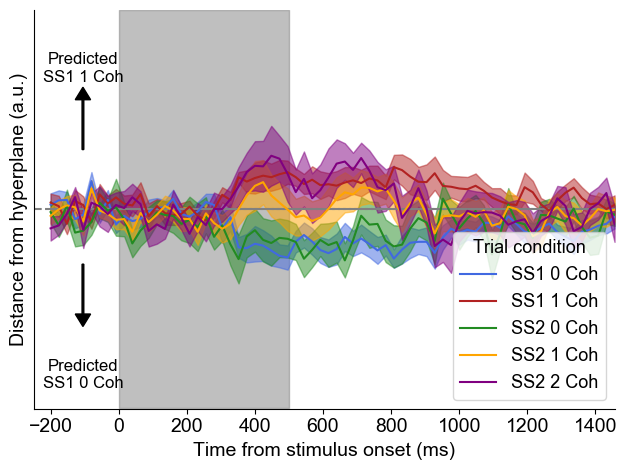

In [31]:
interp_motion.plot_hyperplane(
    subtitle='coh_hyperplane',
    stim_time=[0,500],
    label_text_ys=[-3,2.5],
    train_labels = ['SS1 0 Coh','SS1 1 Coh'],
    savefig=True
)

# attend color 

In [13]:
for isub in range(exp.nsub):
    print(isub)

    xdata,_ = exp.load_eeg(isub)
    beh = pd.DataFrame(exp.load_behavior(isub))
    
    coh_idx = beh['Coherences'].apply(lambda row: int(row[1]))
    ss1_idx = beh.SetSize==1
    # grab attend color trials
    feat_idx = ~np.array(beh['BlockFeature'],dtype=bool)

    xdata, ydata = xdata[ss1_idx&feat_idx], coh_idx[ss1_idx&feat_idx].values

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
interp_color = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_color') 
interp_color.save_results(timestamp=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Significant timepoints: []


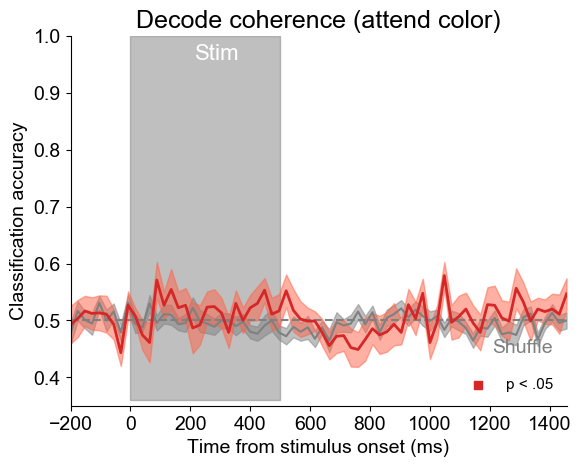

Mean delay accuracy: 0.5025555555555556
Mean delay S.D.: 0.02969931619946913


In [14]:
import matplotlib.pyplot as plt
interp_color.plot_acc(significance_testing=True,savefig=False,
                ylim=[0.35,1],chance_text_xy=(.85,.18),
                title='Decode coherence (attend color)',stim_time=[0,500])
plt.show()

# compare

In [18]:
# Combine acc matrices for plotting
interp = eeg_decoder.Interpreter()
interp.combine_interps(['coh_attend_color','coh_attend_motion'])

Attend Color mean delay accuracy: 0.5025555555555556
Attend Color mean delay S.D.: 0.02969931619946913
Attend Motion mean delay accuracy: 0.562861111111111
Attend Motion mean delay S.D.: 0.030813945355878412
mean delay accuracy: 0.562861111111111
mean delay S.D.: 0.030813945355878412


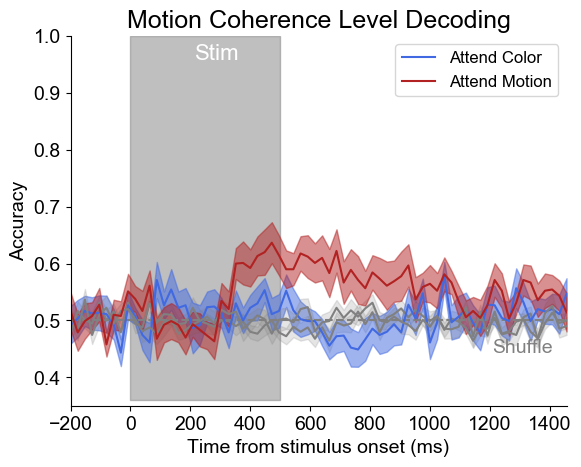

In [19]:
interp.plot_acc_compare_subset(
    subset_list=['Attend Color','Attend Motion'],
    ylim=[.35,1], 
    chance=.5, 
    chance_text_xy=(.85,.18),
    stim_time=[0,500],
    significance_testing=True,
    subtitle='coherence_compare',
    title='Motion Coherence Level Decoding',
    savefig=False)